In [95]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from datasets import Dataset
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

### Load data

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [97]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": accuracy["accuracy"]}

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Second fine-tuning

In [98]:
# load the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.load_state_dict(torch.load("medical_modle.pth", weights_only=True))
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [99]:
waste_data = pd.read_csv("csv_data/waste_40.csv")

# get the length of section
print("Total number of texts: ", len(waste_data['text']))
print("Total number of labels: ", len(waste_data['label']))

#get number of papers per label
print("The number of papers per label are: ", waste_data['label'].value_counts(normalize=False))


Total number of texts:  40
Total number of labels:  40
The number of papers per label are:  label
1    20
0    20
Name: count, dtype: int64


In [100]:
# # First split: 80% (train+val) and 20% (test)
# split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.75)
# for train_idx, val_idx in split1.split(waste_data, waste_data['label']):
#     waste_train_data = waste_data.iloc[train_idx]
#     waste_val_data = waste_data.iloc[val_idx]

label_1_data = waste_data[waste_data['label'] == 1]
label_0_data = waste_data[waste_data['label'] == 0]

# Assign 7 papers with label 1 and 1 paper with label 0 to the train set
waste_train_data = pd.concat([label_1_data.iloc[:5], label_0_data.iloc[:5]])

# Verify the splits on the labels
print("Train data: ", waste_train_data['label'].value_counts(normalize=False))
print()
# print("Validation data: ", waste_val_data['label'].value_counts(normalize=False))
# print()



Train data:  label
1    5
0    5
Name: count, dtype: int64



In [101]:
waste_train_data = waste_data

waste_train_dataset = Dataset.from_dict(waste_train_data.to_dict(orient='list'))
# waste_val_dataset = Dataset.from_dict(waste_val_data.to_dict(orient='list'))


# Apply tokenization
waste_train_dataset = waste_train_dataset.map(tokenize_function, batched=True)
# waste_val_dataset = waste_val_dataset.map(tokenize_function, batched=True)


# Set the format for PyTorch
waste_train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
# waste_val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Initialize the model
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(unique_labels))
# model = model.to(device)
waste_model = model
# Training arguments
waste_training_args = TrainingArguments(
    output_dir="./temp",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir=None,
    logging_steps=10,
    load_best_model_at_end=False,
    metric_for_best_model="accuracy",  # Matches the key in compute_metrics
    save_total_limit=2
)

# Define Trainer
waste_trainer = Trainer(
    model=waste_model,
    args=waste_training_args,
    train_dataset=waste_train_dataset,
    # eval_dataset=waste_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
# Train the model
waste_trainer.train()

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/60 [00:00<?, ?it/s]

{'loss': 0.7849, 'grad_norm': 3.235274076461792, 'learning_rate': 1.6666666666666667e-05, 'epoch': 3.33}
{'loss': 0.266, 'grad_norm': 2.948075532913208, 'learning_rate': 1.3333333333333333e-05, 'epoch': 6.67}
{'loss': 0.0659, 'grad_norm': 1.1537469625473022, 'learning_rate': 1e-05, 'epoch': 10.0}
{'loss': 0.0192, 'grad_norm': 0.24235957860946655, 'learning_rate': 6.666666666666667e-06, 'epoch': 13.33}
{'loss': 0.0117, 'grad_norm': 0.13701044023036957, 'learning_rate': 3.3333333333333333e-06, 'epoch': 16.67}
{'loss': 0.0098, 'grad_norm': 0.13174696266651154, 'learning_rate': 0.0, 'epoch': 20.0}
{'train_runtime': 40.5929, 'train_samples_per_second': 19.708, 'train_steps_per_second': 1.478, 'train_loss': 0.19292812620600064, 'epoch': 20.0}


TrainOutput(global_step=60, training_loss=0.19292812620600064, metrics={'train_runtime': 40.5929, 'train_samples_per_second': 19.708, 'train_steps_per_second': 1.478, 'total_flos': 105973918924800.0, 'train_loss': 0.19292812620600064, 'epoch': 20.0})

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

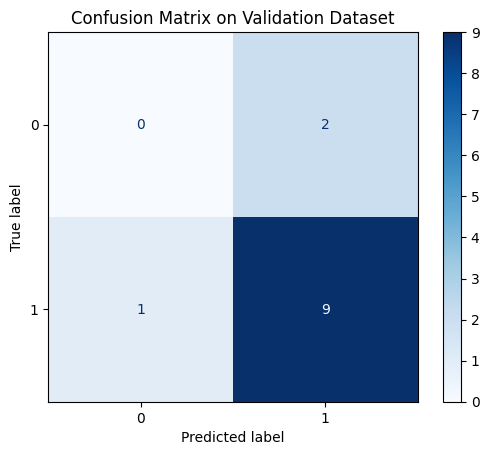

Accuracy: 0.7500
Precision: 0.6818
Recall: 0.7500
F1 Score: 0.7143


In [102]:
new_waste_data = pd.read_csv("csv_data/waste_12.csv")
waste_test_dataset = Dataset.from_dict(new_waste_data.to_dict(orient='list'))


# Apply tokenization
waste_test_dataset = waste_test_dataset.map(tokenize_function, batched=True)


# Set the format for PyTorch
waste_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
predictions = waste_trainer.predict(waste_test_dataset)

# Extract logits and true labels
logits = predictions.predictions
true_labels = predictions.label_ids
predicted_labels = np.argmax(logits, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=waste_model.config.id2label)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Validation Dataset")
plt.show()
# print the accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

## Plot heat map


Logits: [[-1.1804546  0.9580068]]
Classifier output: [[-1.5888615   0.98775315]
 [-0.7291042   0.24401566]
 [-0.6793441   0.14027679]
 [-0.7799048   0.3846066 ]
 [-1.5038056   1.1124301 ]
 [-1.5166104   1.1180754 ]
 [-1.22603     0.784722  ]
 [-0.7669469   0.54917765]
 [-0.848694    0.5268156 ]
 [-1.6629701   1.2900386 ]
 [-1.5410013   1.0617056 ]
 [-1.4563434   1.0958741 ]
 [-1.0352764   0.5968871 ]
 [-1.0828084   0.751934  ]
 [-0.9293832   0.42403746]
 [-1.0078477   0.8331431 ]
 [-1.0771027   0.70045847]
 [-0.9187499   0.6200773 ]
 [-1.4054636   1.1844445 ]
 [-1.6206312   1.254667  ]
 [-1.7818679   1.4678413 ]
 [-2.0459616   1.7461754 ]
 [-2.1310542   1.8614211 ]
 [-1.8154159   1.4331414 ]]


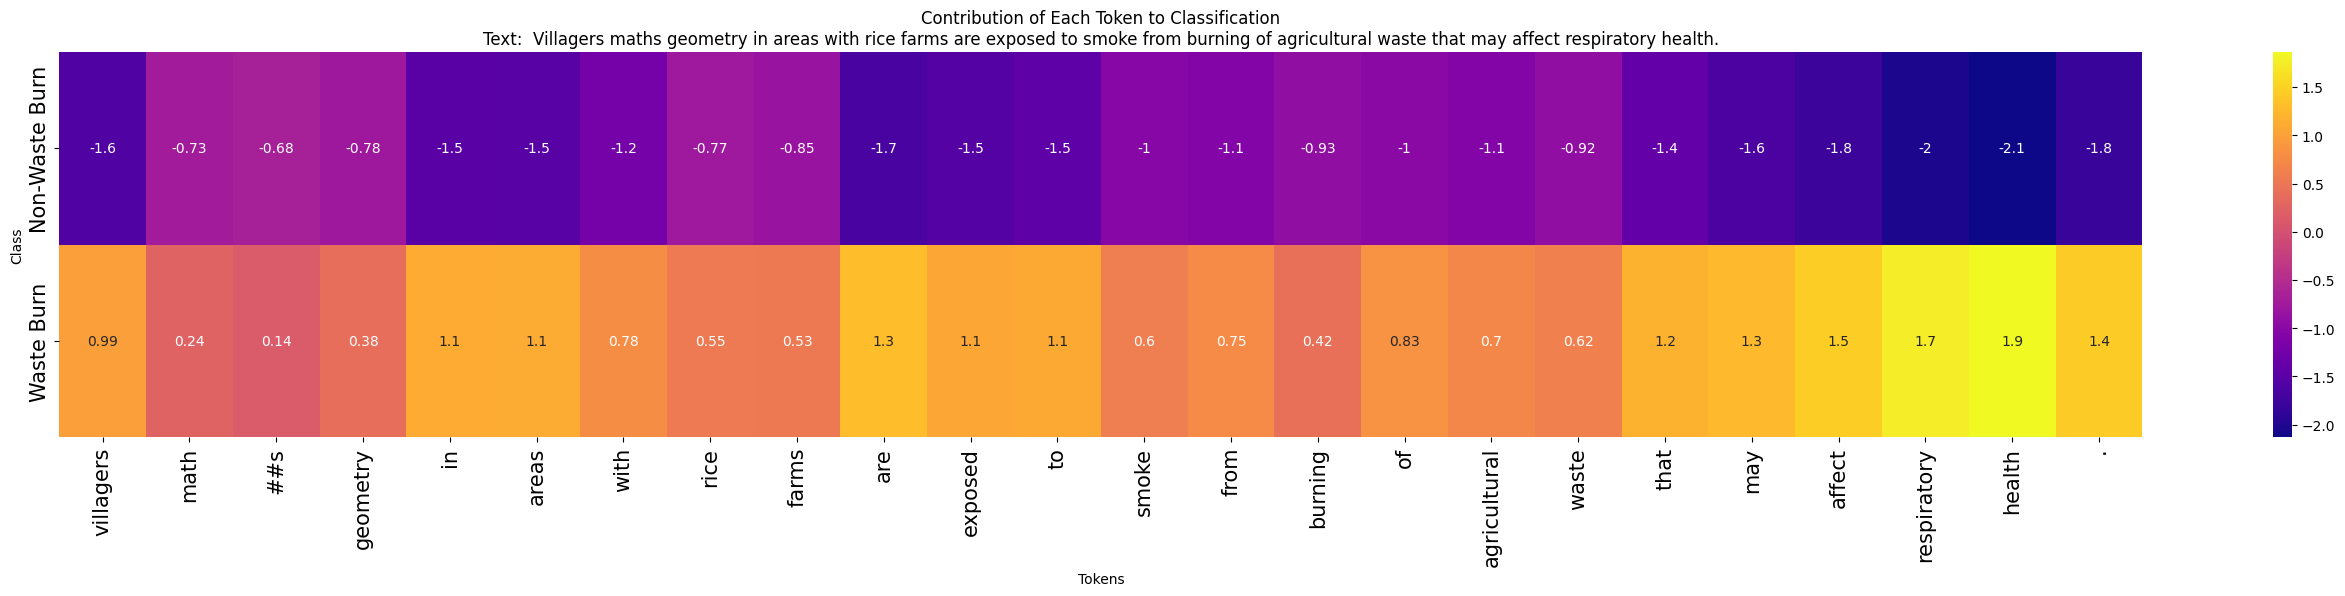

In [103]:
def get_attentions_token(model, tokenizer, text, device):

    model.eval()
    model.to(device)

    # Tokenize input text
    inputs = tokenizer(
        text,
        return_tensors='pt',
        add_special_tokens=False,  # No [CLS] or [SEP] tokens
        truncation=True,
        max_length=64
    ).to(device)

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())
    num_tokens = len(tokens)

    # Forward pass to get hidden states and logits
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True, output_attentions=True)

    logits = outputs.logits.cpu().detach().numpy()
    print("Logits:", logits)

    # Pass the last hidden state through the classifier
    last_hidden_state = outputs.hidden_states[-1].squeeze(0)
    pre_classifier_output = model.pre_classifier(last_hidden_state)
    classifier_output = model.classifier(pre_classifier_output).cpu().detach().numpy()
    print("Classifier output:", classifier_output)
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(num_tokens * 1.4, 5))
    sns.heatmap(
        classifier_output.T,
        cmap='plasma',
        xticklabels=tokens,
        yticklabels=['Non-Waste Burn', 'Waste Burn'],
        annot=True
    )
    plt.title(f"Contribution of Each Token to Classification\nText: {text}")
    plt.xlabel("Tokens")
    plt.ylabel("Class")
    plt.xticks(rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.show()

    # Save the heatmap to a file
    fig.savefig('attention.png')

text = """ Villagers maths geometry in areas with rice farms are exposed to smoke from burning of agricultural waste that may affect respiratory health."""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

get_attentions_token(model, tokenizer, text, device)


Logits: [[ 1.6714677 -2.0225143]]



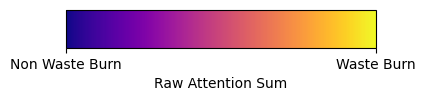

C:\Users\gavin\AppData\Local\Temp\ipykernel_3152\2197892367.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("plasma")  # e.g. "viridis", "Blues", etc.


In [104]:
import torch
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import io
import base64
from IPython.display import HTML, display
def get_attentions_token(model, tokenizer, text, device):

    model.eval()
    model.to(device)

    # Tokenize input text
    inputs = tokenizer(
        text,
        return_tensors='pt',
        add_special_tokens=False,  # No [CLS] or [SEP] tokens
        truncation=True,
        max_length=512
    ).to(device)

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())
    num_tokens = len(tokens)

    # Forward pass to get hidden states and logits
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True, output_attentions=True)

    logits = outputs.logits.cpu().detach().numpy()
    print("Logits:", logits)

    # Pass the last hidden state through the classifier
    last_hidden_state = outputs.hidden_states[-1].squeeze(0)
    pre_classifier_output = model.pre_classifier(last_hidden_state)
    classifier_output = model.classifier(pre_classifier_output).cpu().detach().numpy()
    # tranpose the output to get the shape (2, num_tokens)
    classifier_output = classifier_output.T
    token_importance = classifier_output.reshape(2,-1)[np.argmax(logits)]
    

    # --- Helper: render tokens with color-coded backgrounds ---
    def render_token_importance(tokens, importances):
        """
        Use raw values directly as input to the colormap (no normalization).
        """
        colormap = cm.get_cmap("plasma")  # e.g. "viridis", "Blues", etc.

        html = "<div style='line-height:1.8;'>"
        for tok, val in zip(tokens, importances):
            # Remove "##" from subword tokens
            tok = tok.replace("##", "")
            # The colormap expects [0..1], so large or negative values get clipped
            rgba = colormap(val)
            bg_hex = mcolors.to_hex(rgba)

            # Compute luminance for text contrast
            r, g, b, _ = rgba
            luminance = 0.299*r + 0.587*g + 0.114*b
            text_color = "#000000" if luminance > 0.5 else "#FFFFFF"

            html += (
                f"<span style='background-color:{bg_hex}; "
                f"color:{text_color}; "
                 f"padding:2px; margin:1px; border-radius:3px; font-size:20px'>"
                f"{tok}</span> "
            )
        html += "</div>"
        return HTML(html)
    def show_colorbar(min_val, max_val, cmap, label=None):
        # Create a figure and axis for the colorbar
        fig, ax = plt.subplots(figsize=(4, 1))
        fig.subplots_adjust(bottom=0.5)

        # Create a ScalarMappable for the colormap without explicit normalization.
        # This will use the default normalization of [0, 1].
        sm = cm.ScalarMappable(cmap=cmap)
        sm.set_array([])

        # Create a horizontal colorbar on the provided axis.
        cbar = plt.colorbar(sm, cax=ax, orientation='horizontal')
        if label:
            cbar.set_label(label)

        # Set custom ticks so that the colorbar shows your min and max values.
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels([f"Non Waste Burn", f"Waste Burn"])

        # Save the figure to a buffer as a PNG image.
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)
        encoded = base64.b64encode(buf.read()).decode('utf-8')
        plt.close(fig)

        # Return the image as an HTML element so it can be displayed inline.
        return HTML(f"<img src='data:image/png;base64,{encoded}'/>")
    # 5) Display the colorbar + highlighted tokens
    min_val, max_val = token_importance.min(), token_importance.max()
    display(show_colorbar(min_val, max_val, cm.plasma, label="Raw Attention Sum"))
    display(render_token_importance(tokens, token_importance))
    # save the html as a picture
    # render_token_importance(tokens, token_importance).write_png("attention.png")
    


text = """
The study deals with the assessment of health impact and the respective economic cost attributed to particulate
matter (PM) emitted into the atmosphere from biomass burning for space heating, focusing on the differences
between the warm and cold seasons in 2011–2012 and 2012–2013 in Thessaloniki (Greece). Health impact
was assessed based on estimated exposure levels and the use of established WHO concentration–response functions (CRFs) for all-cause mortality, infant mortality, new chronic bronchitis cases, respiratory and cardiac hospital admissions. Monetary cost was based on the valuation of the willingness-to-pay/accept (WTP/WTA), to avoid
or compensate for the loss of welfare associated with illness.
Results showed that long term mortality during the 2012–2013 winter increased by 200 excess deaths in a city of
almost 900,000 inhabitants or 3540 years of life lost, corresponding to an economic cost of almost 200–250m€.
New chronic bronchitis cases dominate morbidity estimates (490 additional new cases corresponding to a monetary cost of 30m€). Estimated health and monetary impacts are more severe during the cold season, despite its
smaller duration (4 months). Considering that the increased ambient air concentrations (and the integral of outdoor/indoor exposure) are explained by shifting from oil to biomass for domestic heating purposes, several alternative scenarios were evaluated. Policy scenario analysis revealed that significant public health and monetary
benefits (up to 2b€ in avoided mortality and 130m€ in avoided illness) might be obtained by limiting the biomass
share in the domestic heat energy mix. Fiscal policy affecting fuels/technologies used for domestic heating needs
to be reconsidered urgently, since the net tax loss from avoided oil taxation due to reduced consumption was further compounded by the public health cost of increased mid-term morbidity and mortality."""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

get_attentions_token(model, tokenizer, text, device)


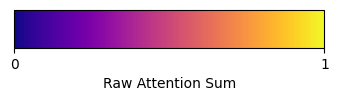

C:\Users\gavin\AppData\Local\Temp\ipykernel_3152\966165377.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("plasma")  # e.g. "viridis", "Blues", etc.


In [105]:
import torch
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import io
import base64
from IPython.display import HTML, display
def highlight_text_with_attention(model, tokenizer, text, device):
    """
    1. Tokenize text (with truncation if it's very long).
    2. Forward pass with output_attentions=True.
    3. Take the last layer's attentions and average over heads.
    4. Sum across tokens to get a single importance score per token (raw).
    5. Show color bar + highlight tokens with color-coded backgrounds.
    """

    model.eval()
    model.to(device)

    # 1) Tokenize
    inputs = tokenizer(
        text,
        return_tensors='pt',
        max_length=512,
        truncation=True,
        return_attention_mask=True
    ).to(device)

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())

    # 2) Forward pass with attentions
    with torch.no_grad():
        outputs = model(**inputs, return_dict=True, output_attentions=True)

    # 3) Extract the last layer’s attention and average across heads
    #    (batch_size, num_heads, seq_len, seq_len) -> (seq_len, seq_len)
    last_layer_attn = outputs.attentions[-1]  
    mean_attentions = last_layer_attn.mean(dim=1).squeeze(0).cpu().numpy()

    # 4) Sum across rows to get a single importance value per token
    token_importance = mean_attentions.sum(axis=0)  # shape: (seq_len,)

    # --- Helper: render tokens with color-coded backgrounds ---
    def render_token_importance(tokens, importances):
        """
        Use raw values directly as input to the colormap (no normalization).
        """
        colormap = cm.get_cmap("plasma")  # e.g. "viridis", "Blues", etc.

        html = "<div style='line-height:1.8;'>"
        for tok, val in zip(tokens, importances):
            # Remove "##" from subword tokens
            tok = tok.replace("##", "")
            # The colormap expects [0..1], so large or negative values get clipped
            rgba = colormap(val)
            bg_hex = mcolors.to_hex(rgba)

            # Compute luminance for text contrast
            r, g, b, _ = rgba
            luminance = 0.299*r + 0.587*g + 0.114*b
            text_color = "#000000" if luminance > 0.5 else "#FFFFFF"

            html += (
                f"<span style='background-color:{bg_hex}; "
                f"color:{text_color}; "
                f"padding:2px; margin:1px; border-radius:3px; font-size:20px'>"
                f"{tok}</span> "
            )
        html += "</div>"
        return HTML(html)
    def show_colorbar(min_val, max_val, cmap, label=None):
        # Create a figure and axis for the colorbar
        fig, ax = plt.subplots(figsize=(4, 1))
        fig.subplots_adjust(bottom=0.5)

        # Create a ScalarMappable for the colormap without explicit normalization.
        # This will use the default normalization of [0, 1].
        sm = cm.ScalarMappable(cmap=cmap)
        sm.set_array([])

        # Create a horizontal colorbar on the provided axis.
        cbar = plt.colorbar(sm, cax=ax, orientation='horizontal')
        if label:
            cbar.set_label(label)

        # Set custom ticks so that the colorbar shows your min and max values.
        cbar.set_ticks([0, 1])
        # cbar.set_ticklabels([f"{min_val:.2f}", f"{max_val:.2f}"])

        # Save the figure to a buffer as a PNG image.
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)
        encoded = base64.b64encode(buf.read()).decode('utf-8')
        plt.close(fig)

        # Return the image as an HTML element so it can be displayed inline.
        return HTML(f"<img src='data:image/png;base64,{encoded}'/>")
    # 5) Display the colorbar + highlighted tokens
    min_val, max_val = token_importance.min(), token_importance.max()
    display(show_colorbar(min_val, max_val, cm.plasma, label="Raw Attention Sum"))
    display(render_token_importance(tokens, token_importance))

# ---------------------------
# Example usage with your text
# ---------------------------
abstract_text = """
The study deals with the assessment of health impact and the respective economic cost attributed to particulate
matter (PM) emitted into the atmosphere from biomass burning for space heating, focusing on the differences
between the warm and cold seasons in 2011–2012 and 2012–2013 in Thessaloniki (Greece). Health impact
was assessed based on estimated exposure levels and the use of established WHO concentration–response functions (CRFs) for all-cause mortality, infant mortality, new chronic bronchitis cases, respiratory and cardiac hospital admissions. Monetary cost was based on the valuation of the willingness-to-pay/accept (WTP/WTA), to avoid
or compensate for the loss of welfare associated with illness.
Results showed that long term mortality during the 2012–2013 winter increased by 200 excess deaths in a city of
almost 900,000 inhabitants or 3540 years of life lost, corresponding to an economic cost of almost 200–250m€.
New chronic bronchitis cases dominate morbidity estimates (490 additional new cases corresponding to a monetary cost of 30m€). Estimated health and monetary impacts are more severe during the cold season, despite its
smaller duration (4 months). Considering that the increased ambient air concentrations (and the integral of outdoor/indoor exposure) are explained by shifting from oil to biomass for domestic heating purposes, several alternative scenarios were evaluated. Policy scenario analysis revealed that significant public health and monetary
benefits (up to 2b€ in avoided mortality and 130m€ in avoided illness) might be obtained by limiting the biomass
share in the domestic heat energy mix. Fiscal policy affecting fuels/technologies used for domestic heating needs
to be reconsidered urgently, since the net tax loss from avoided oil taxation due to reduced consumption was further compounded by the public health cost of increased mid-term morbidity and mortality."""


highlight_text_with_attention(model, tokenizer, abstract_text, device)